<a href="https://colab.research.google.com/github/Kritikargv17/Deep-Learning-LAB/blob/main/Exp14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.74MB/s]


Epoch [1/5]  VAE Loss=13043.86  D Loss=0.03  G Loss=6.01
Epoch [2/5]  VAE Loss=10282.42  D Loss=0.25  G Loss=5.27
Epoch [3/5]  VAE Loss=9278.75  D Loss=2.82  G Loss=2.63
Epoch [4/5]  VAE Loss=8505.47  D Loss=1.35  G Loss=1.67
Epoch [5/5]  VAE Loss=8777.16  D Loss=2.02  G Loss=1.78


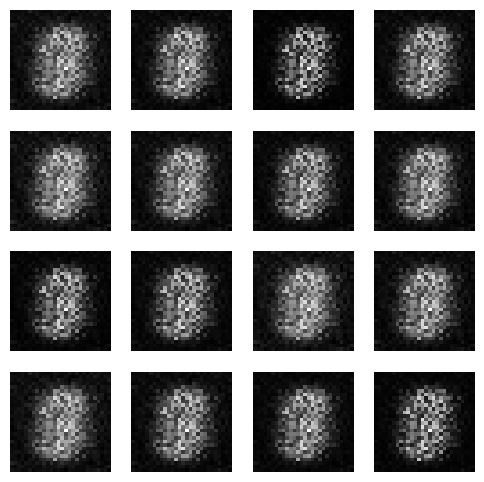

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================================================
#                  DATASET & DATALOADER
# ================================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)


# ================================================================
#                           VAE
# ================================================================
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, 20)
        self.fc_logvar = nn.Linear(128, 20)

        self.decoder = nn.Sequential(
            nn.Linear(20, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        h = self.encoder(x)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)
        return out, mu, logvar


def vae_loss(recon, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon, x.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# ================================================================
#                     GAN (Generator + Discriminator)
# ================================================================
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.view(-1, 28 * 28)
        return self.model(img)


# ================================================================
#                         INITIALIZE MODELS
# ================================================================
vae = VAE().to(device)
G = Generator().to(device)
D = Discriminator().to(device)

lr = 0.0002
optimizer_vae = optim.Adam(vae.parameters(), lr=lr)
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

criterion = nn.BCELoss()


# ================================================================
#                         TRAINING LOOP
# ================================================================
num_epochs = 5

for epoch in range(num_epochs):
    for batch, (images, _) in enumerate(train_loader):

        images = images.to(device)

        # ===========================================
        #                   TRAIN VAE
        # ===========================================
        recon, mu, logvar = vae(images)
        loss_vae = vae_loss(recon, images, mu, logvar)

        optimizer_vae.zero_grad()
        loss_vae.backward()
        optimizer_vae.step()

        # ===========================================
        #               TRAIN DISCRIMINATOR
        # ===========================================
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(images.size(0), 100).to(device)
        fake_imgs = G(z)

        outputs = D(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # ===========================================
        #                TRAIN GENERATOR
        # ===========================================
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  VAE Loss={loss_vae.item():.2f}  D Loss={d_loss.item():.2f}  G Loss={g_loss.item():.2f}")

# ================================================================
#                       SHOW RESULTS
# ================================================================
z = torch.randn(16, 100).to(device)
samples = G(z).view(-1, 1, 28, 28).cpu().detach()

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()